`page 333`

# Chapter 8

## Exercise 7

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
#from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import statsmodels.api as sm

In [2]:
# Debugging with birdseye
%load_ext birdseye

In [8]:
boston = sm.datasets.get_rdataset('Boston', package='MASS').data
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [9]:
boston.shape

(506, 14)

In [10]:
# split into X and y variables
X = boston.drop('medv', axis=1)
y = boston['medv']

In [11]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

First, lets soon with bagging, which is simply a special case of random forest with $m = p$. Manual *pruning* is not supported in `sklearn`, but we can limit the depth with `max_depth` parameter of `RandomForestRegressor()`.

In [19]:
# fit the model
forest = RandomForestRegressor(max_features=13).fit(X_train, y_train)

# get scores. The default is MSE
print('Explained varinace in train: {:.3f} \nExplained variance in test: {:.3f}'
      .format(forest.score(X_train, y_train), forest.score(X_test, y_test)))

Explained varinace in train: 0.979 
Explained variance in test: 0.833


C:\Users\Ali Sina\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
# Visualizing the random forest
export_graphviz(forest.estimators_[5], out_file='boston_forest.dot', feature_names=X.columns)

os.system('dot -Tpng boston_forest.dot -o boston_forest.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'boston_forest.png')

**I cannot visualize it here because some issues with my OS. But here above is how you visualize a single decision tree.**
An alternative is to use `pydot` library like so:
```
import pydot
graph, = print_tree(tree, features=["some features names"])
from IPython.display import Image
Image(graph.create_png())
```

## Exercise 8

In [3]:
carseats = sm.datasets.get_rdataset('Carseats', package='ISLR').data
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

In [13]:
# create dummy variables from the features
X = pd.get_dummies(X)
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes
0,138,73,11,276,120,42,17,1,0,0,0,1,0,1
1,111,48,16,260,83,65,10,0,1,0,0,1,0,1
2,113,35,10,269,80,59,12,0,0,1,0,1,0,1
3,117,100,4,466,97,55,14,0,0,1,0,1,0,1
4,141,64,3,340,128,38,13,1,0,0,0,1,1,0


Drop these columns to avoid the [dummy variable trap](https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables). **Remember** that `pd.get_dummies` itself will drop one of them with the `drop_first=True` parameter.

In [15]:
# Each dummy set, one of the encoded columns must be dropped
X = X.drop(['ShelveLoc_Bad', 'Urban_No', 'US_No'], axis=1)
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,17,0,0,1,1
1,111,48,16,260,83,65,10,1,0,1,1
2,113,35,10,269,80,59,12,0,1,1,1
3,117,100,4,466,97,55,14,0,1,1,1
4,141,64,3,340,128,38,13,0,0,1,0


In [17]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# fit model
regressor = DecisionTreeRegressor().fit(X_train, y_train)
mean_squared_error(y_test, regressor.predict(X_test))

4.429911000000001

#### **Using GridSearchCV to find the optimal `max_depth`**

In [41]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6]}

grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5).fit(X_train, y_train)
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [42]:
grid_search.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Above shows that a `max_depth` of $3$ was chosen by the `GridSearchCV` as the optimal level of complexity.

In [43]:
# Getting the mean test error rate from grid search
np.mean(grid_search.cv_results_['mean_test_score'])

0.3204430375677604

In [40]:
# This shows the ranking of best max_depth for the decision tree
grid_search.cv_results_['rank_test_score']

array([6, 5, 1, 2, 3, 4])

**Bagging** is simply a decision tree with $m = p$.

In [45]:
# Decision tree with bagging
regressor = DecisionTreeRegressor(max_features=len(X_train.columns)).fit(X_train, y_train)
mean_squared_error(y_test, regressor.predict(X_test))

4.326727000000001

In [48]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5).fit(X_train, y_train)
grid_search.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=11,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [49]:
# Test error with bagging and max_depth chosen by GridSearchCV
np.mean(grid_search.cv_results_['mean_test_score'])

0.3037345815524453

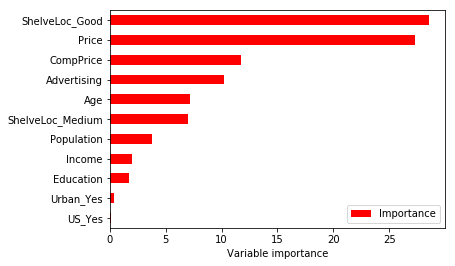

In [50]:
# Variable importance
importance = pd.DataFrame({'Importance': regressor.feature_importances_*100}, index=X_train.columns)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable importance')
plt.legend(loc='lower right')

***
## Exercise 9

In [3]:
oj = sm.datasets.get_rdataset('OJ', package='ISLR').data
oj.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


I drop `WeekofPurchase` because this is a time-series feature. We could encode `StoreID` but I decided it's not an important feature, so I dropped it.

In [62]:
X = oj.drop(['Purchase', 'WeekofPurchase', 'StoreID', 'STORE'], axis=1)
y = oj['Purchase']

# dummy vars of Store7
X = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

X_train.head()

,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,Store7_Yes
983,1.86,2.13,0.37,0.0,1,0,0.49280,2.13,1.49,0.64,0.000000,0.198925,0.27,1
338,1.86,2.18,0.00,0.0,0,0,0.03917,2.18,1.86,0.32,0.000000,0.000000,0.32,1
269,1.86,2.18,0.00,0.0,0,0,0.53376,2.18,1.86,0.32,0.000000,0.000000,0.32,0
74,1.69,1.99,0.00,0.0,0,1,0.68000,1.99,1.69,0.30,0.000000,0.000000,0.30,1
327,1.86,1.99,0.00,0.1,0,0,0.56480,1.89,1.86,0.03,0.050251,0.000000,0.13,0


In [106]:
# fit to train
classifier = DecisionTreeClassifier(random_state=123).fit(X_train, y_train)

# predictions
y_preds = classifier.predict(X_test)

# get confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_preds).T, index=['CH', 'MM'], columns=['CH', 'MM'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,CH,MM
Predicted,,
CH,146,40
MM,45,90


In [107]:
# grid search cv to find optimal max_depth
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=5).fit(X_train, y_train)
grid_search.best_estimator_

C:\Users\Ali Sina\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

`GridSeachCV` chose `max_depth=4` as the optimal tree size.

In [108]:
# using Sklearn's classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

          CH       0.78      0.76      0.77       191
          MM       0.67      0.69      0.68       130

   micro avg       0.74      0.74      0.74       321
   macro avg       0.73      0.73      0.73       321
weighted avg       0.74      0.74      0.74       321



In [117]:
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

Text(0, 0.5, 'Test Score')

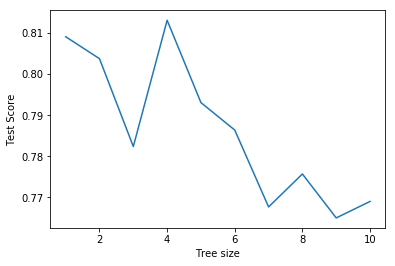

In [132]:
plt.plot(np.arange(1, 11), grid_search.cv_results_['mean_test_score'])
plt.xlabel('Tree size')
plt.ylabel('Test Score')

***
## Exercise 10

In [152]:
hitters = sm.datasets.get_rdataset('Hitters', package='ISLR').data
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [137]:
# missing values?
hitters.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [153]:
# drop NA rows
hitters.dropna(inplace=True)
hitters.shape

(263, 20)

In [156]:
# create dummy variables for the couple of categorical columns
# drop_first removes the refernce column
hitters = pd.get_dummies(hitters, drop_first=True)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


### **Boosting**

In [176]:
X = hitters.drop('Salary', axis=1)
y = np.log(hitters['Salary'])

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=123)

# lambda shrinkage values to use (are usually small values like 0.001 or 0.01)
lambdas = 10**np.arange(-5, -0.2, 0.1)

# fit gradient boosting for all lambdas
all_mse = [] 
for i in lambdas:
    boosting_clf = GradientBoostingRegressor(learning_rate=i, n_estimators=1000, 
                                              random_state=123, max_depth=4)
    boosting_clf.fit(X_train, y_train)
    preds = boosting_clf.predict(X_test)
    mse = mean_squared_error(y_test, preds)     # test MSEs
    all_mse.append(mse)

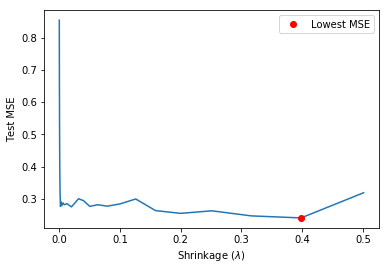

In [260]:
plt.plot(lambdas, all_mse)

# Can alternatively use numpy:
#plt.plot(lambdas[all_mse.index(min(all_mse))], min(all_mse), 'ro')
plt.plot(lambdas[np.argmin(all_mse)], min(all_mse), 'ro', label='Lowest MSE')

plt.xlabel('Shrinkage ($\lambda$)')
plt.ylabel('Test MSE')
plt.legend()

In [261]:
min(all_mse)

0.24080205211322103

### **Bagging**

Simply a tree with $m = p$.

In [262]:
# Decision tree with bagging
regressor = DecisionTreeRegressor(max_features=len(X_train.columns)).fit(X_train, y_train)
mean_squared_error(y_test, regressor.predict(X_test))

0.429105658134476

## $Fin$